<a href="https://colab.research.google.com/github/wubeshetA/HahuNet/blob/main/src/HahuNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HahuNet**
HahuNet a convolutional Neural Network to recognize handwritten amharic alphabet characters.

## Procedures
0. Introduction
1. Data Loading
2. Data Preprocessing
3. Model Architecture
4. Training
5. Evaluation
6. Model Improvement (Regularization, Optimization)
7. Evaluation (Iterate until high accuracy is achieved)
8. Test data Prediction


# 0. Introduction

Amharic, primarily spoken in Ethiopia, is written using a version of the Ge’ez script known as Fidel. It's estimated over 50 million people speaks the amharic globally. Despite its widespread use, there are limited resources available for the digital recognition of handwritten Amharic text.

This project aims to address this gap by developing a Machine Learning (ML) model capable of recognizing the handwritten Amharic alphabet. The successful implementation of this project could have a significant social impact, particularly in the fields of education, communication, and digitization of historical documents.

### The Alphabet (Fidel)
The Amharic Alphabet has 238 characters in total with 34 base characters and 6 child characters for each base characters (34X7 = 238). Please have a look at the following figure for better understanding.

![fig1](/content/assets/alphabets2.jpg)


## The data

The Dataset is 28x28 pixel image and and in total there are 32,920 images that would be splitted to training, evaluation, and test dataset.

### import packages

In [1]:
# import packages and modules
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


## 1. Load data

In [ ]:
# This is specific to google collab runtime enviroment.
# As the number of dataset is large uploading the images directly to the collab takes time.
#  So, a zip file is uploaded to a google drive and extract it here.

drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/Colab Notebooks/amharic_dataset/dataset.zip" -d "/content/"


In [3]:
class AmharicDataset:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_filenames = os.listdir(data_dir)

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        image = Image.open(os.path.join(self.data_dir, filename)).convert('L')
        image = np.array(image)
        image = tf.convert_to_tensor(image, dtype=tf.uint8)
        label = int(filename.split('.')[0]) - 1
        return image, label

    def __len__(self):
        return len(self.image_filenames)

In [4]:
def load_train_test_data():
    dataset = AmharicDataset('/content/dataset')
    # Get all the datasets
    all_images = dataset.image_filenames

    # Split the dataset into training and test data
    train_images, test_images = train_test_split(all_images, test_size=0.1, random_state=42)

    # Create separate datasets for training and test
    train_dataset = [dataset[idx] for idx in range(len(dataset)) if dataset.image_filenames[idx] in train_images]
    test_dataset = [dataset[idx] for idx in range(len(dataset)) if dataset.image_filenames[idx] in test_images]
    return train_dataset, test_dataset

In [5]:
train_dataset, test_dataset = load_train_test_data()

In [7]:
len(train_dataset)

29628

In [8]:


def split_train_test_data(train_dataset, test_dataset):
    # Convert train and test datasets to numpy arrays
    X_train_orig, Y_train_orig = zip(*train_dataset)
    X_test_orig, Y_test_orig = zip(*test_dataset)

    # Convert to numpy arrays
    X_train_orig = np.array(X_train_orig).reshape(-1, X_train_orig[0].shape[0], X_train_orig[0].shape[1], 1)
    X_test_orig = np.array(X_test_orig).reshape(-1, X_test_orig[0].shape[0], X_test_orig[0].shape[1], 1)
    Y_train_orig = np.array(Y_train_orig).reshape(-1, 1)
    Y_test_orig = np.array(Y_test_orig).reshape(-1, 1)

    return X_train_orig, Y_train_orig, X_test_orig, Y_test_orig


In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = split_train_test_data(train_dataset, test_dataset)

In [10]:
X_test_orig.shape


(3292, 28, 28, 1)

In [11]:
Y_train_orig[35]

array([116])

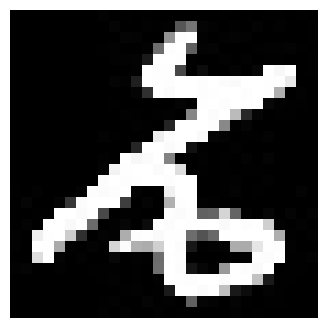

In [12]:

index = 35
# Display the image with smaller window size and in grayscale
plt.figure(figsize=(4, 4))  # Set the figure size to a smaller window size
plt.imshow(X_train_orig[index], cmap='gray')  # Display the image in grayscale
plt.axis('off')  # Turn off axis labels
plt.show()


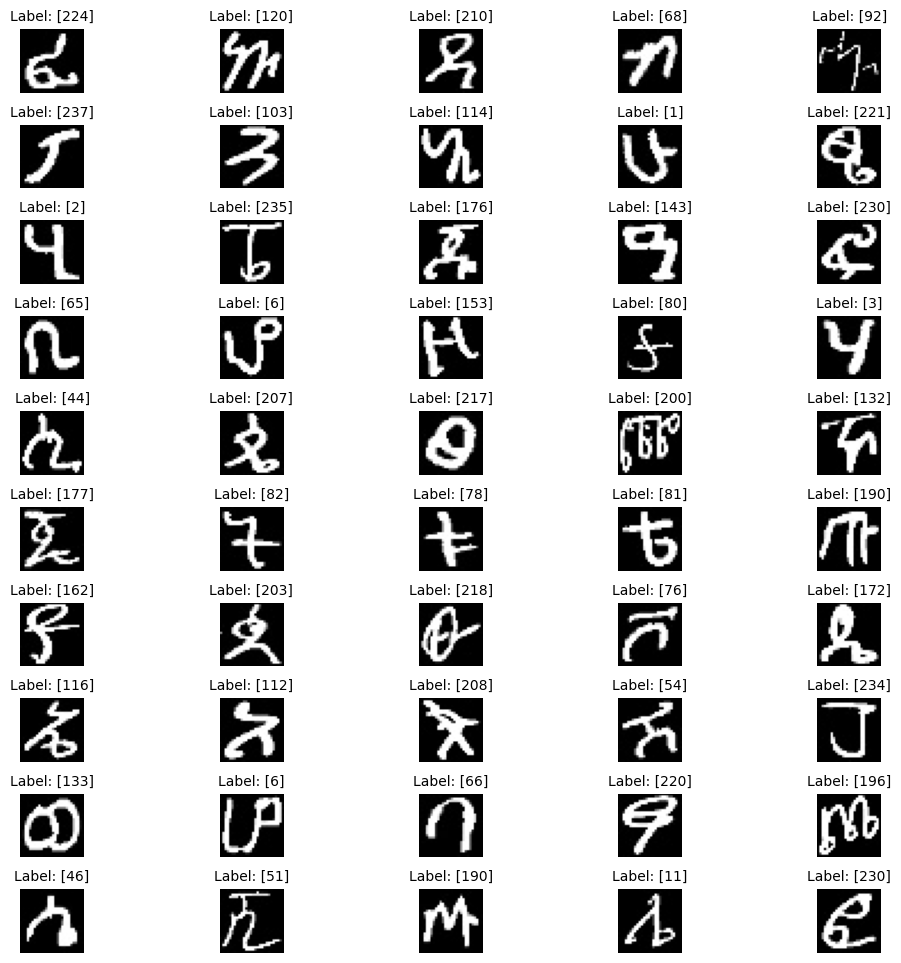

In [ ]:
import matplotlib.pyplot as plt

def display_images_with_labels(images, labels, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))  # Set the figure size and layout
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            axes[i, j].imshow(images[index], cmap='gray')  # Display the image in grayscale
            axes[i, j].set_title(f"Label: {labels[index]}", fontsize=10)  # Set the title with the label
            axes[i, j].axis('off')  # Turn off axis labels

    plt.show()

# Example usage:
display_images_with_labels(X_train_orig[:50], Y_train_orig[:50], rows=10, cols=5)


# Model - without optimazation

In [13]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
encoder = OneHotEncoder(sparse=False)

Y_train = encoder.fit_transform(Y_train_orig)
Y_test = encoder.transform(Y_test_orig)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
Y_train.shape

(29628, 238)

In [ ]:

class HahuNet:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self._build_model()

    def _build_model(self):
        self.model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape, padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        self.model.compile( loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, Y_train, epochs, batch_size):
        self.history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

    def evaluate(self, X_test, Y_test):
        return self.model.evaluate(X_test, Y_test)

    def summary(self):
        self.model.summary()


In [15]:

class HahuNet1:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self._build_model()

    def _build_model(self):
        self.model = Sequential([
            Conv2D(16, (3, 3), activation='relu', input_shape=self.input_shape, padding='valid'),
            MaxPooling2D((2, 2)),
            Conv2D(32, (5, 5), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (9, 9), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        self.model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    def train(self, X_train, Y_train, epochs, batch_size):
        self.history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

    def evaluate(self, X_test, Y_test):
        return self.model.evaluate(X_test, Y_test)

    def summary(self):
        self.model.summary()


In [16]:

# Create an instance of the model
input_shape = (28, 28, 1)
num_classes = 238
model = HahuNet1(input_shape, num_classes)

# Training the model
epochs = 20
batch_size = 64
model.train(X_train, Y_train, epochs, batch_size)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/20
417/417 [==============================] - 56s 132ms/step - loss: 3.3343 - accuracy: 0.2616 - val_loss: 1.3890 - val_accuracy: 0.6102
Epoch 2/20
417/417 [==============================] - 52s 125ms/step - loss: 1.2570 - accuracy: 0.6296 - val_loss: 0.7709 - val_accuracy: 0.7658
Epoch 3/20
417/417 [==============================] - 52s 125ms/step - loss: 0.7928 - accuracy: 0.7551 - val_loss: 0.5932 - val_accuracy: 0.8157
Epoch 4/20
417/417 [==============================] - 54s 130ms/step - loss: 0.5863 - accuracy: 0.8138 - val_loss: 0.5296 - val_accuracy: 0.8377
Epoch 5/20
417/417 [==============================] - 53s 128ms/step - loss: 0.4677 - accuracy: 0.8466 - val_loss: 0.5080 - val_accuracy: 0.8407
Epoch 6/20
417/417 [==============================] - 52s 125ms/step - loss: 0.3726 - accuracy: 0.8748 - val_loss: 0.4829 - val_accuracy: 0.8485
Epoch 7/20
417/417 [==============================] - 53s 127ms/step - loss: 0.3093 - accuracy: 0.8962 - val_loss: 0.4774 - val_ac

## Visualize loss and accuracy

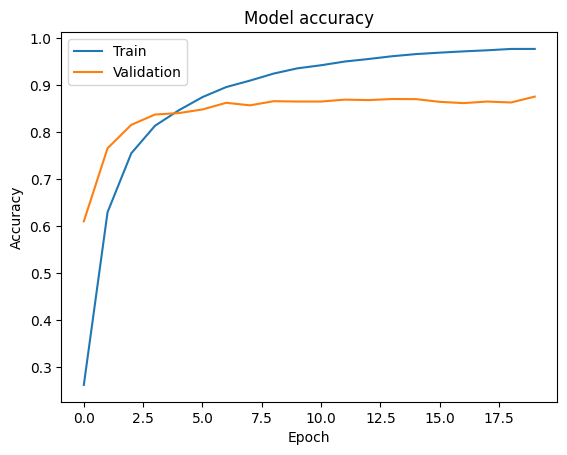

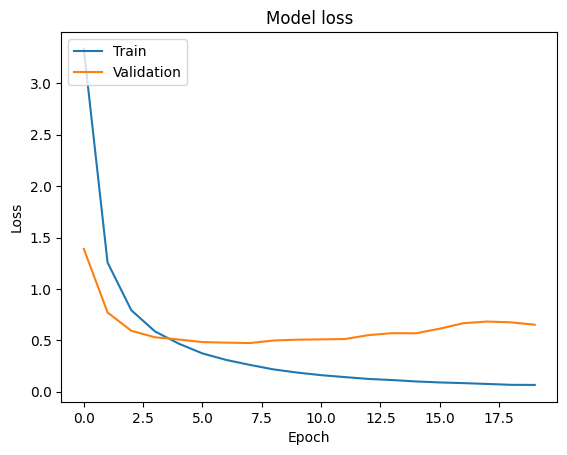

In [17]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Example usage:
plot_training_history(model.history)


## Save Model

In [19]:
import pickle

# Save the trained model to a pickle file
with open('/content/hahunet_model_1.pkl', 'wb') as file:
    pickle.dump(model, file)
